In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

tickers = ["TSLA", "BND", "SPY"]
start_date = "2015-07-01"
end_date = "2025-07-31"

print("Fetching data from YFinance...")
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']

print("\n--- Initial Data Head ---\n", data.head())
print("\n--- Initial Data Info ---\n")
data.info()

print("\nFilling missing values with the forward-fill method...")
data.ffill(inplace=True)

data.dropna(inplace=True)

print("\nMissing values after cleaning:\n", data.isnull().sum())
print("\n--- Cleaned Data Head ---\n", data.head())

print("\n--- Descriptive Statistics for Closing Prices ---\n")
print(data.describe())


Fetching data from YFinance...


[*********************100%***********************]  3 of 3 completed


--- Initial Data Head ---
 Ticker            BND         SPY       TSLA
Date                                        
2015-07-01  60.816723  174.917130  17.943333
2015-07-02  60.967102  174.756866  18.667999
2015-07-06  61.177551  174.259583  18.648001
2015-07-07  61.237679  175.355423  17.858667
2015-07-08  61.410641  172.413513  16.997334

--- Initial Data Info ---

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2535 entries, 2015-07-01 to 2025-07-30
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BND     2535 non-null   float64
 1   SPY     2535 non-null   float64
 2   TSLA    2535 non-null   float64
dtypes: float64(3)
memory usage: 79.2 KB

Filling missing values with the forward-fill method...

Missing values after cleaning:
 Ticker
BND     0
SPY     0
TSLA    0
dtype: int64

--- Cleaned Data Head ---
 Ticker            BND         SPY       TSLA
Date                                        
2015-07-01  60.816723 

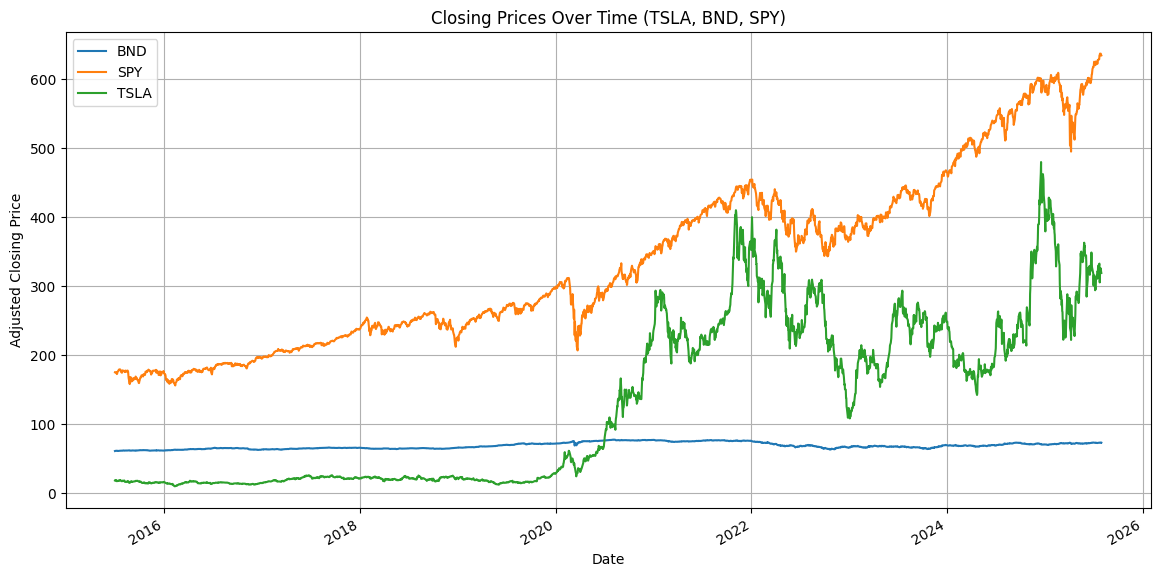

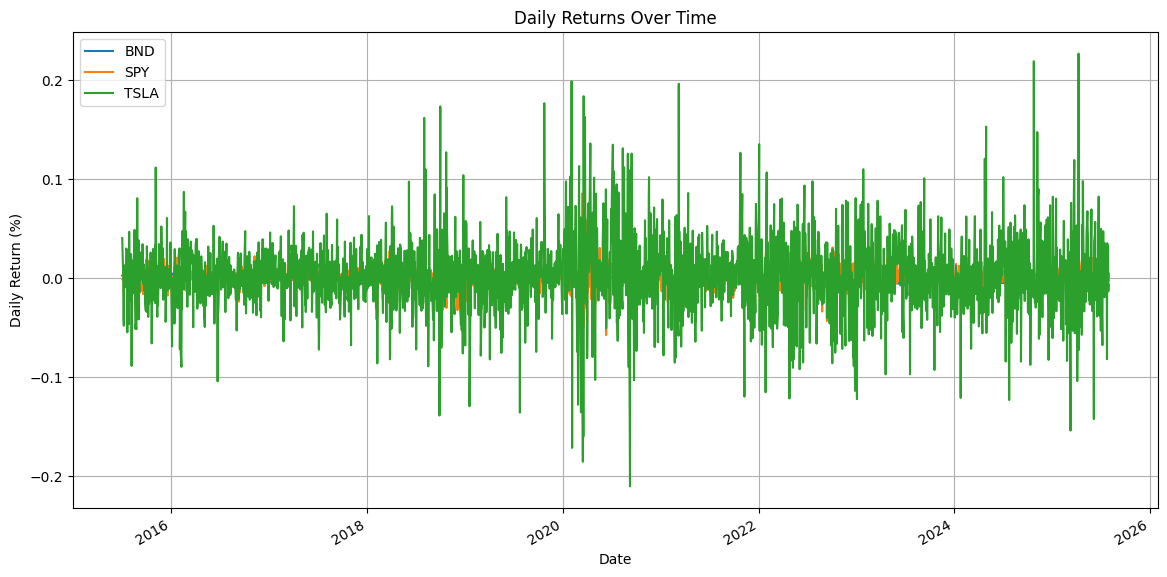

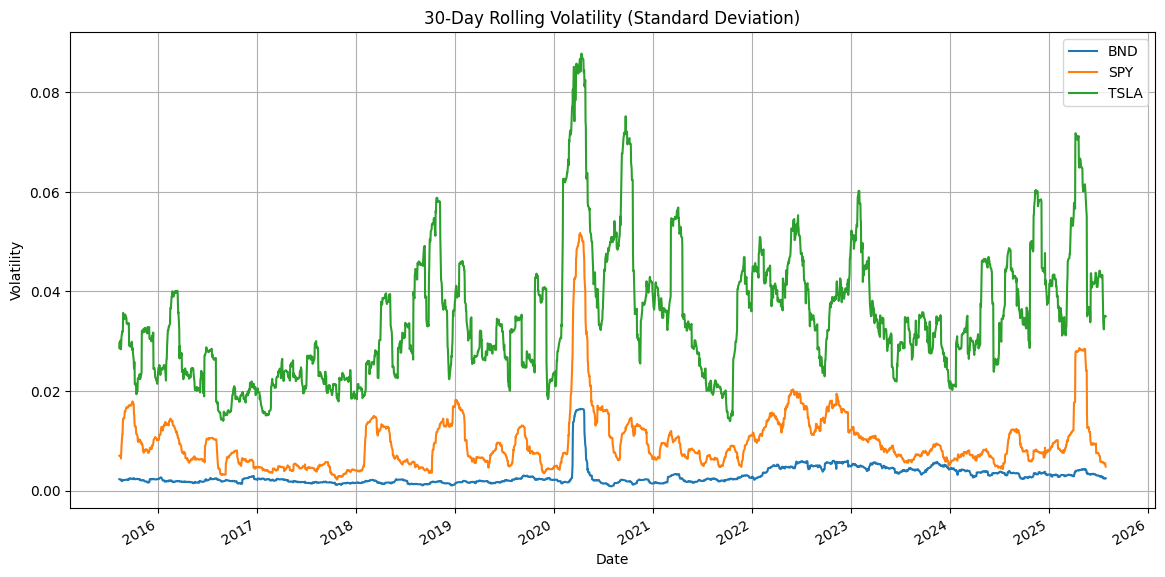

In [3]:
import matplotlib.pyplot as plt

# Calculate daily returns
daily_returns = data.pct_change().dropna()

# Calculate rolling statistics for a 30-day window
rolling_mean = daily_returns.rolling(window=30).mean()
rolling_std = daily_returns.rolling(window=30).std()

# --- Plotting Closing Prices ---
plt.figure(figsize=(14, 7))
data.plot(ax=plt.gca())
plt.title('Closing Prices Over Time (TSLA, BND, SPY)')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price')
plt.grid(True)
plt.legend()
plt.show()

# --- Plotting Daily Returns ---
plt.figure(figsize=(14, 7))
daily_returns.plot(ax=plt.gca())
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.grid(True)
plt.legend()
plt.show()

# --- Plotting Rolling Volatility ---
plt.figure(figsize=(14, 7))
rolling_std.plot(ax=plt.gca())
plt.title('30-Day Rolling Volatility (Standard Deviation)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.legend()
plt.show()


In [4]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name):
    print(f"\n--- Augmented Dickey-Fuller Test for {name} ---")
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Values: {result[4]}")
    if result[1] <= 0.05:
        print("Conclusion: The series is likely stationary (p-value <= 0.05).")
    else:
        print("Conclusion: The series is likely non-stationary (p-value > 0.05).")

for ticker in daily_returns.columns:
    adf_test(data[ticker], f"{ticker} Closing Prices")
    adf_test(daily_returns[ticker], f"{ticker} Daily Returns")

print("\n--- Foundational Risk Metrics ---")

risk_free_rate = 0.0175

metrics = {}
for ticker in daily_returns.columns:
    annual_return = daily_returns[ticker].mean() * 252
    annual_volatility = daily_returns[ticker].std() * np.sqrt(252)
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility
    var_95 = np.percentile(daily_returns[ticker], 5)
    
    metrics[ticker] = {
        'Annual Return': annual_return,
        'Annual Volatility': annual_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'VaR (95%)': var_95
    }

metrics_df = pd.DataFrame(metrics).T
print(metrics_df)



--- Augmented Dickey-Fuller Test for BND Closing Prices ---
ADF Statistic: -1.5363
p-value: 0.5155
Critical Values: {'1%': np.float64(-3.432946577138947), '5%': np.float64(-2.8626871581881708), '10%': np.float64(-2.5673806760176046)}
Conclusion: The series is likely non-stationary (p-value > 0.05).

--- Augmented Dickey-Fuller Test for BND Daily Returns ---
ADF Statistic: -9.8898
p-value: 0.0000
Critical Values: {'1%': np.float64(-3.4329579682301254), '5%': np.float64(-2.8626921885291017), '10%': np.float64(-2.5673833542324727)}
Conclusion: The series is likely stationary (p-value <= 0.05).

--- Augmented Dickey-Fuller Test for SPY Closing Prices ---
ADF Statistic: 0.6908
p-value: 0.9897
Critical Values: {'1%': np.float64(-3.4329424595562963), '5%': np.float64(-2.862685339846278), '10%': np.float64(-2.5673797079109892)}
Conclusion: The series is likely non-stationary (p-value > 0.05).

--- Augmented Dickey-Fuller Test for SPY Daily Returns ---
ADF Statistic: -16.2644
p-value: 0.0000
C